In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from processing_functions import *

In [74]:
df = pd.read_csv('data/input_file.csv')
nan_percentage(df) 

NaN % Unnamed: 0: 0.00%
NaN % iid: 0.00%
NaN % id: 0.01%
NaN % wave: 0.00%
NaN % partner: 0.00%
NaN % pid: 0.12%
NaN % match: 0.00%
NaN % int_corr: 1.89%
NaN % age_o: 1.24%
NaN % pf_o_att: 1.06%
NaN % pf_o_sin: 1.06%
NaN % pf_o_int: 1.06%
NaN % pf_o_fun: 1.17%
NaN % pf_o_amb: 1.28%
NaN % pf_o_sha: 1.54%
NaN % dec_o: 0.00%
NaN % attr_o: 2.53%
NaN % sinc_o: 3.43%
NaN % intel_o: 3.65%
NaN % fun_o: 4.30%
NaN % amb_o: 8.62%
NaN % shar_o: 12.84%
NaN % like_o: 2.98%
NaN % prob_o: 3.80%
NaN % met_o: 4.60%
NaN % age: 1.13%
NaN % imprelig: 0.94%
NaN % goal: 0.94%
NaN % date: 1.16%
NaN % go_out: 0.94%
NaN % sports: 0.94%
NaN % tvsports: 0.94%
NaN % exercise: 0.94%
NaN % dining: 0.94%
NaN % museums: 0.94%
NaN % art: 0.94%
NaN % hiking: 0.94%
NaN % gaming: 0.94%
NaN % clubbing: 0.94%
NaN % reading: 0.94%
NaN % tv: 0.94%
NaN % theater: 0.94%
NaN % movies: 0.94%
NaN % concerts: 0.94%
NaN % music: 0.94%
NaN % shopping: 0.94%
NaN % yoga: 0.94%
NaN % exphappy: 1.21%
NaN % expnum: 78.52%
NaN % attr_impor

There is a lot of data missing for how people think others perceive them, and what attributes they think the rest of their sex prefer. 

Since I am also going to be working with no gender, I will drop any column related to the binary separation of gender.

The attribute that overall has the most amount of missing data is 'shared interests'. I was hoping to use this attribute as a reliable feature to find partners, but based on the findings made in the EDA it is the feature that is the least important. 

In [76]:
def drop_columns(df, suffix):
    cols = [col for col in df.columns if any(col.endswith(s) for s in suffix)]
    
    df = df.drop(columns=cols, errors='ignore')
    
    return df
    

suffix= ['_fellow_want', 'perceived', '_o_want', '_diff']
df = drop_columns(df, suffix)
df = df.drop(columns=['Unnamed: 0'])

Since there are too many people and waves in this experiment, I am going to opt to drop the rows that have nan values so that it is easier to work with when it comes to training the dataset (especially with Random Forest). 

In [77]:
df.head()

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
2,1,1.0,1,3,13.0,1,0.16,22.0,19.0,18.0,...,4,1,5.0,8.0,9.0,8.0,5.0,7.0,7.0,NaN
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0


In [78]:
df = df.dropna()
df

,iid,id,wave,partner,pid,match,int_corr,age_o,pf_o_att,pf_o_sin,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,1,1.0,1,1,11.0,0,0.14,27.0,35.0,20.0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,1,1.0,1,2,12.0,0,0.54,22.0,60.0,0.0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,1.0,1,4,14.0,1,0.61,23.0,30.0,5.0,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,1.0,1,5,15.0,1,0.21,24.0,30.0,10.0,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,1,1.0,1,6,16.0,0,0.25,25.0,50.0,0.0,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,131,10.0,5,1,112.0,0,0.35,20.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1837,131,10.0,5,2,113.0,0,0.45,21.0,15.0,15.0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1838,131,10.0,5,3,114.0,0,0.13,20.0,20.0,20.0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1840,131,10.0,5,5,116.0,0,0.54,21.0,15.0,15.0,...,1,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0


In [79]:
# Dropping identifier columns and irrelevant features for prediction
df = df.drop(columns=['iid', 'id', 'pid', 'partner', 'wave'], axis=1)

In [80]:
df

,match,int_corr,age_o,pf_o_att,pf_o_sin,pf_o_int,pf_o_fun,pf_o_amb,pf_o_sha,dec_o,...,amb_self,dec,attr,sinc,intel,fun,amb,shar,like,prob
0,0,0.14,27.0,35.0,20.0,20.0,20.0,0.0,5.0,0,...,4,1,6.0,9.0,7.0,7.0,6.0,5.0,7.0,6.0
1,0,0.54,22.0,60.0,0.0,0.0,40.0,0.0,0.0,0,...,4,1,7.0,8.0,7.0,8.0,5.0,6.0,7.0,5.0
3,1,0.61,23.0,30.0,5.0,15.0,40.0,5.0,5.0,1,...,4,1,7.0,6.0,8.0,7.0,6.0,8.0,7.0,6.0
4,1,0.21,24.0,30.0,10.0,20.0,10.0,10.0,20.0,1,...,4,1,5.0,6.0,7.0,7.0,6.0,6.0,6.0,6.0
5,0,0.25,25.0,50.0,0.0,30.0,10.0,0.0,10.0,1,...,4,0,4.0,9.0,7.0,4.0,6.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,0,0.35,20.0,15.0,15.0,20.0,25.0,10.0,15.0,0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1837,0,0.45,21.0,15.0,15.0,25.0,25.0,15.0,5.0,0,...,2,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1838,0,0.13,20.0,20.0,20.0,20.0,20.0,10.0,10.0,0,...,3,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0
1840,0,0.54,21.0,15.0,15.0,25.0,25.0,20.0,0.0,0,...,1,0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,1.0


In [81]:
X = df.drop(['match', 'dec', 'dec_o'], axis=1)
y = df['match']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [82]:
# Start by modelling a LightGBM and Random Forest model 
# Will do comparison of both and decide based on 

lgb_model = lgb.LGBMClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)

lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 204, number of negative: 784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000973 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 988, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206478 -> initscore=-1.346289
[LightGBM] [Info] Start training from score -1.346289


RandomForestClassifier(random_state=42)

In [83]:
rf_accuracy = cross_val_score(rf_model, X_train, y_train, cv=5)
lgb_accuracy = cross_val_score(lgb_model, X_train, y_train, cv=5)

print("Random Forest Accuracy: ", rf_accuracy.mean())
print("LightGBM Accuracy: ", lgb_accuracy.mean())

[LightGBM] [Info] Number of positive: 163, number of negative: 627
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 758
[LightGBM] [Info] Number of data points in the train set: 790, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.206329 -> initscore=-1.347196
[LightGBM] [Info] Start training from score -1.347196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

 99%|===================| 1665/1676 [00:12<00:00]        

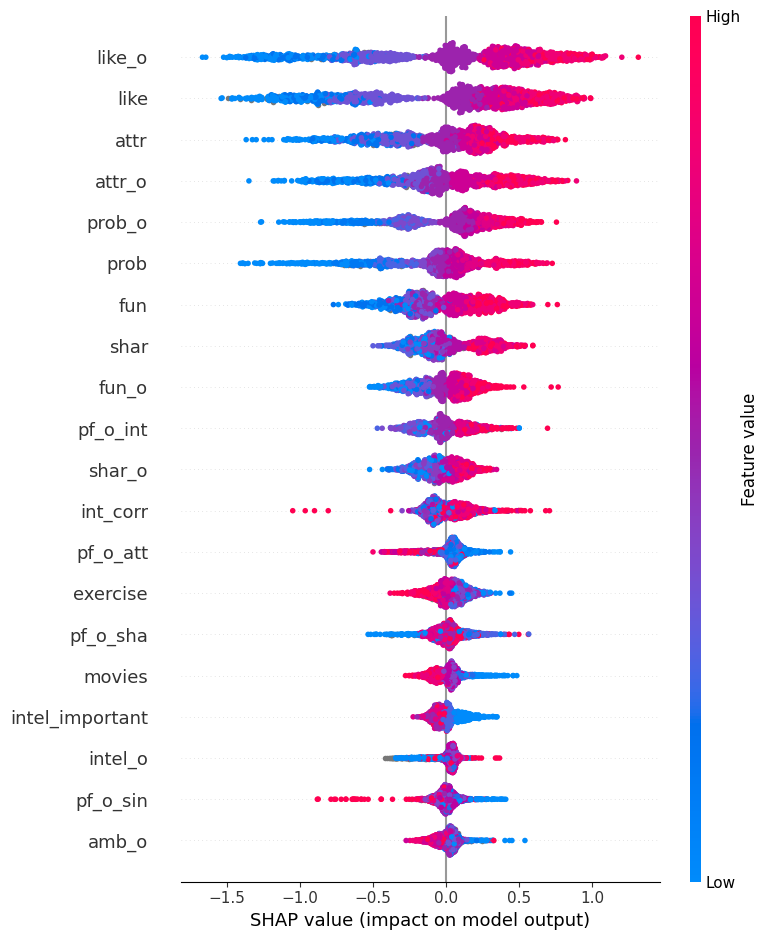

In [38]:
import shap

explainer = shap.Explainer(lgb_model, X_train)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)

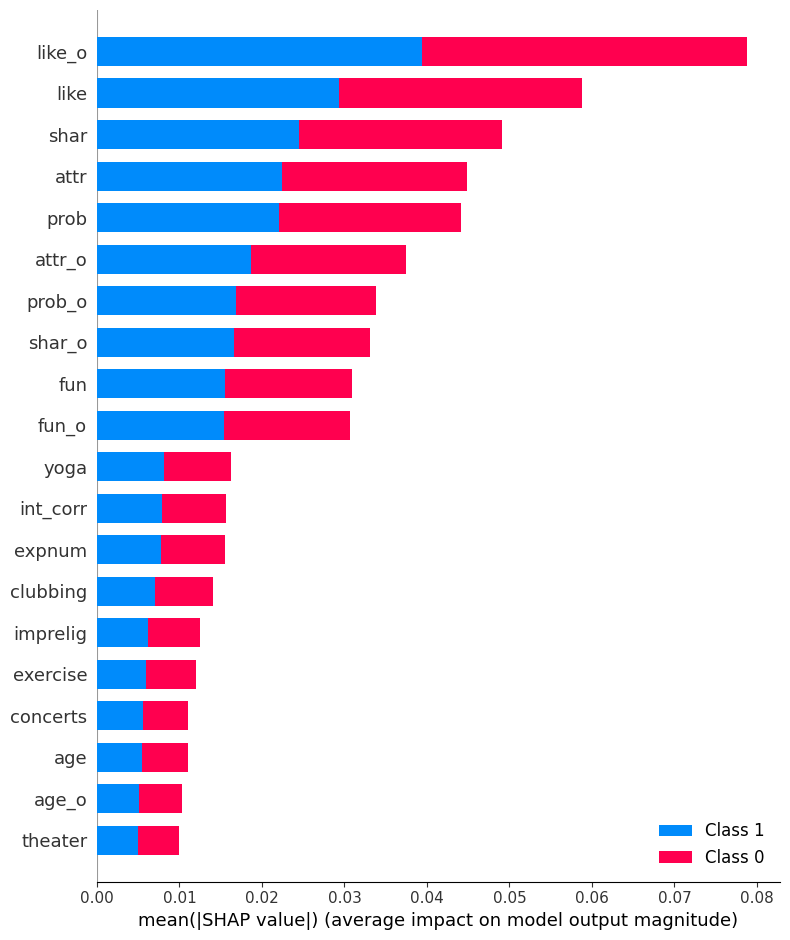

In [91]:
explainer = shap.TreeExplainer(rf_model, check_additivity=False)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test)